Import necessary libraries:

In [1]:
import torch
import string
import time
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW, AutoModelForMaskedLM

2024-06-30 04:31:27.374071: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 04:31:27.374200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 04:31:27.506312: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Install packages:

In [2]:
! pip install hazm
! pip install langdetect
! pip install googletrans==3.1.0a0

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.4.1 requires cubinlinker, which is not installed.
cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.4.1 req

In [3]:
from hazm import *
from langdetect import detect
from googletrans import Translator

## Preprocessing

In [4]:
train_path = "/kaggle/input/digikala-commetns/original 2.csv"
test_path  = "/kaggle/input/digikala-commetns/test (1).csv"

In [5]:
columns = ["text", "label"]

train_df = pd.read_csv(train_path, names=columns)
test_df  = pd.read_csv(test_path, names=columns)

In [6]:
train_df.head()

,text,label
0,گوشي خوبيه(قوي و شکيل و زيبا و بي رقيب)البته ت...,1
1,سلام خيلي خوبه بخرين.,2
2,از جمله قابلیت‌های ارتباطی HTC Desire SV می‌تو...,0
3,نهایتا، یک دوربین VGA نیز برای انجام مکالمات ...,0
4,من حدوداً ۱ ماهي‌ که مي‌شه اين گوشي رو دارم، ر...,1


In [7]:
test_df.head()

,text,label
0,اندازه ي خوبي داره .,1
1,با اين چيزا نميتونه از Galaxy S III بهتر باشه,-1
2,سرعت اجرا بسيار بالا است و مصرف باتري نيز مناس...,2
3,از حساسیت 400 مقداری نویز در عکس ها مشاهده می ...,1
4,در کل، با اینکه عکاسی با تبلت را همواره جزو م...,1


In [8]:
mapping = {-2: -1, -1: -1, 0: 0, 1: 1, 2: 1}

train_df["label"] = train_df["label"].map(mapping)
test_df["label"]  = test_df["label"].map(mapping)

In [9]:
train_df.head()

,text,label
0,گوشي خوبيه(قوي و شکيل و زيبا و بي رقيب)البته ت...,1
1,سلام خيلي خوبه بخرين.,1
2,از جمله قابلیت‌های ارتباطی HTC Desire SV می‌تو...,0
3,نهایتا، یک دوربین VGA نیز برای انجام مکالمات ...,0
4,من حدوداً ۱ ماهي‌ که مي‌شه اين گوشي رو دارم، ر...,1


In [10]:
test_df.head()

,text,label
0,اندازه ي خوبي داره .,1
1,با اين چيزا نميتونه از Galaxy S III بهتر باشه,-1
2,سرعت اجرا بسيار بالا است و مصرف باتري نيز مناس...,1
3,از حساسیت 400 مقداری نویز در عکس ها مشاهده می ...,1
4,در کل، با اینکه عکاسی با تبلت را همواره جزو م...,1


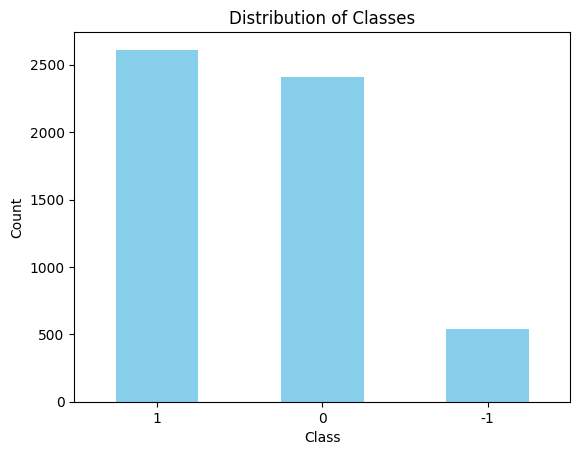

In [11]:
class_distribution = train_df['label'].value_counts()
class_distribution.plot(kind='bar', rot=0, color='skyblue')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes')

plt.show()

In [12]:
def count_tokens(text):
    count = word_tokenize(text)
    return len(count)

train_df['num_tokens'] = train_df['text'].apply(count_tokens)

In [13]:
train_df.head()

,text,label,num_tokens
0,گوشي خوبيه(قوي و شکيل و زيبا و بي رقيب)البته ت...,1,19
1,سلام خيلي خوبه بخرين.,1,5
2,از جمله قابلیت‌های ارتباطی HTC Desire SV می‌تو...,0,30
3,نهایتا، یک دوربین VGA نیز برای انجام مکالمات ...,0,18
4,من حدوداً ۱ ماهي‌ که مي‌شه اين گوشي رو دارم، ر...,1,91


In [14]:
total_traininig_tokens  = train_df['num_tokens'].sum()
print(f"Total number of tokens in the traininig set before preprocessing: {total_traininig_tokens}")

Total number of tokens in the traininig set before preprocessing: 130150


In [15]:
normalizer = Normalizer()
stemmer = Stemmer()
stop_words = set(stopwords_list())
punctuation = set(string.punctuation)

def preprocessing(text):
    normalized =  normalizer.normalize(text)
    tokens = word_tokenize(normalized)

    def preprocess_token(token):
        try:
            lang = detect(token)
        except:
            lang = 'non-Persian'
        
        if lang == 'fa':
            if token in stop_words or token in punctuation:
                return ''
            return stemmer.stem(token)
        else:
            return ''
    
    preprocessed_tokens = [preprocess_token(token) for token in tokens]
    preprocessed_tokens = [token for token in preprocessed_tokens if token]
    
    
    processed_text = ' '.join(preprocessed_tokens)
    return processed_text

In [16]:
train_df['processed_text'] = train_df['text'].apply(preprocessing)
test_df['processed_text']  = test_df['text'].apply(preprocessing)

In [17]:
train_df['processed_num_tokens'] = train_df['processed_text'].apply(count_tokens)
total_training_tokens = train_df['processed_num_tokens'].sum()

print(f"Total number of tokens in the training set after preprocessing: {total_training_tokens}")

test_df['processed_num_tokens'] = test_df['processed_text'].apply(count_tokens)

Total number of tokens in the training set after preprocessing: 39810


### Split data

In [23]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=313)
print("Train data shape:", train_df.shape)
print("Validation data shape:", val_df.shape)

Train data shape: (4448, 5)
Validation data shape: (1113, 5)


In [24]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

## 2.2. FaBert - without augmentation

In [18]:
tokenizer = AutoTokenizer.from_pretrained("sbunlp/fabert")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForSequenceClassification.from_pretrained("sbunlp/fabert", num_labels=3)
model = model.to(device)
print(model)

tokenizer_config.json:   0%|          | 0.00/18.3k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/552k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/589 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sbunlp/fabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [19]:
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters before unfreezing: {num_trainable_params}")

Number of trainable parameters before unfreezing: 124443651


In [20]:
for param in model.parameters():
    param.requires_grad = False
    
for param in model.classifier.parameters():
    param.requires_grad = True

In [21]:
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters after unfreezing the classifier: {num_trainable_params}")

Number of trainable parameters after unfreezing the classifier: 2307


In [22]:
for param in model.bert.encoder.layer[-1].parameters():
    param.requires_grad = True

num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters after unfreezing classifier and tha lask block: {num_trainable_params}")

Number of trainable parameters after unfreezing classifier and tha lask block: 7090179


In [25]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [26]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        
        label = int(label)
        label = torch.tensor(label, dtype=torch.long)
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': label
        }

In [27]:
print(f"Mean comment length: {train_df['processed_num_tokens'].mean()}")

Mean comment length: 7.226393884892087


In [28]:
max_length = 20
batch_size = 16
num_epochs = 5

In [29]:
model = model.to(device)

In [30]:
mapping = {-1: 0, 0: 1, 1: 2}

train_df['label'] = train_df['label'].map(mapping)
val_df['label']   = val_df['label'].map(mapping)
test_df['label']  = test_df['label'].map(mapping)

In [31]:
train_dataset = TextDataset(train_df['processed_text'], train_df['label'], tokenizer, max_length)
val_dataset   = TextDataset(val_df['processed_text'], val_df['label'], tokenizer, max_length)
test_dataset  = TextDataset(test_df['processed_text'], test_df['label'], tokenizer, max_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size)

In [32]:
def calculate_accuracy(preds, labels):
    rounded_preds = torch.argmax(preds, dim=1)
    
    correct = (rounded_preds == labels).float()
    accuracy = correct.sum() / len(correct)
    
    return accuracy

train_losses1 = []
train_accuracies1 = []
val_losses1 = []
val_accuracies1 = []

def evaluate_model(model, dataloader, device):
    model.eval()
    losses = []
    accuracies = []
    for batch in dataloader:
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            # Accumulate loss
            losses.append(loss.item())

            # Calculate accuracy
            batch_accuracy = calculate_accuracy(logits, labels)
            accuracies.append(batch_accuracy.item())

    avg_loss = np.mean(losses)
    avg_accuracy = np.mean(accuracies)

    return avg_loss, avg_accuracy


model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    epoch_train_accuracy = 0.0

    # Training loop
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        # Move tensors to the device explicitly
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumulate training loss and accuracy
        epoch_train_loss += loss.item()
        logits = outputs.logits
        batch_accuracy = calculate_accuracy(logits, labels)
        epoch_train_accuracy += batch_accuracy.item()

    epoch_train_loss /= len(train_dataloader)
    epoch_train_accuracy /= len(train_dataloader)
    train_losses1.append(epoch_train_loss)
    train_accuracies1.append(epoch_train_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss}, Train Accuracy: {epoch_train_accuracy}")

    # Evaluation on validation set
    epoch_val_loss, epoch_val_accuracy = evaluate_model(model, val_dataloader, device)
    val_losses1.append(epoch_val_loss)
    val_accuracies1.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {epoch_val_accuracy}")

Epoch 1/5, Train Loss: 1.015805179266621, Train Accuracy: 0.4748201438848921
Epoch 1/5, Validation Loss: 0.9480691773550851, Validation Accuracy: 0.4531746031982558
Epoch 2/5, Train Loss: 0.9301298387187849, Train Accuracy: 0.5143884892086331
Epoch 2/5, Validation Loss: 0.930761843919754, Validation Accuracy: 0.5235119049038206
Epoch 3/5, Train Loss: 0.9012430438892447, Train Accuracy: 0.5512589928057554
Epoch 3/5, Validation Loss: 0.9183902731963567, Validation Accuracy: 0.5449404763323921
Epoch 4/5, Train Loss: 0.873181156760497, Train Accuracy: 0.5701438848920863
Epoch 4/5, Validation Loss: 0.8985955893993378, Validation Accuracy: 0.5768849206822259
Epoch 5/5, Train Loss: 0.8420016060201384, Train Accuracy: 0.5950989208633094
Epoch 5/5, Validation Loss: 0.8840935604912894, Validation Accuracy: 0.5813492063965117


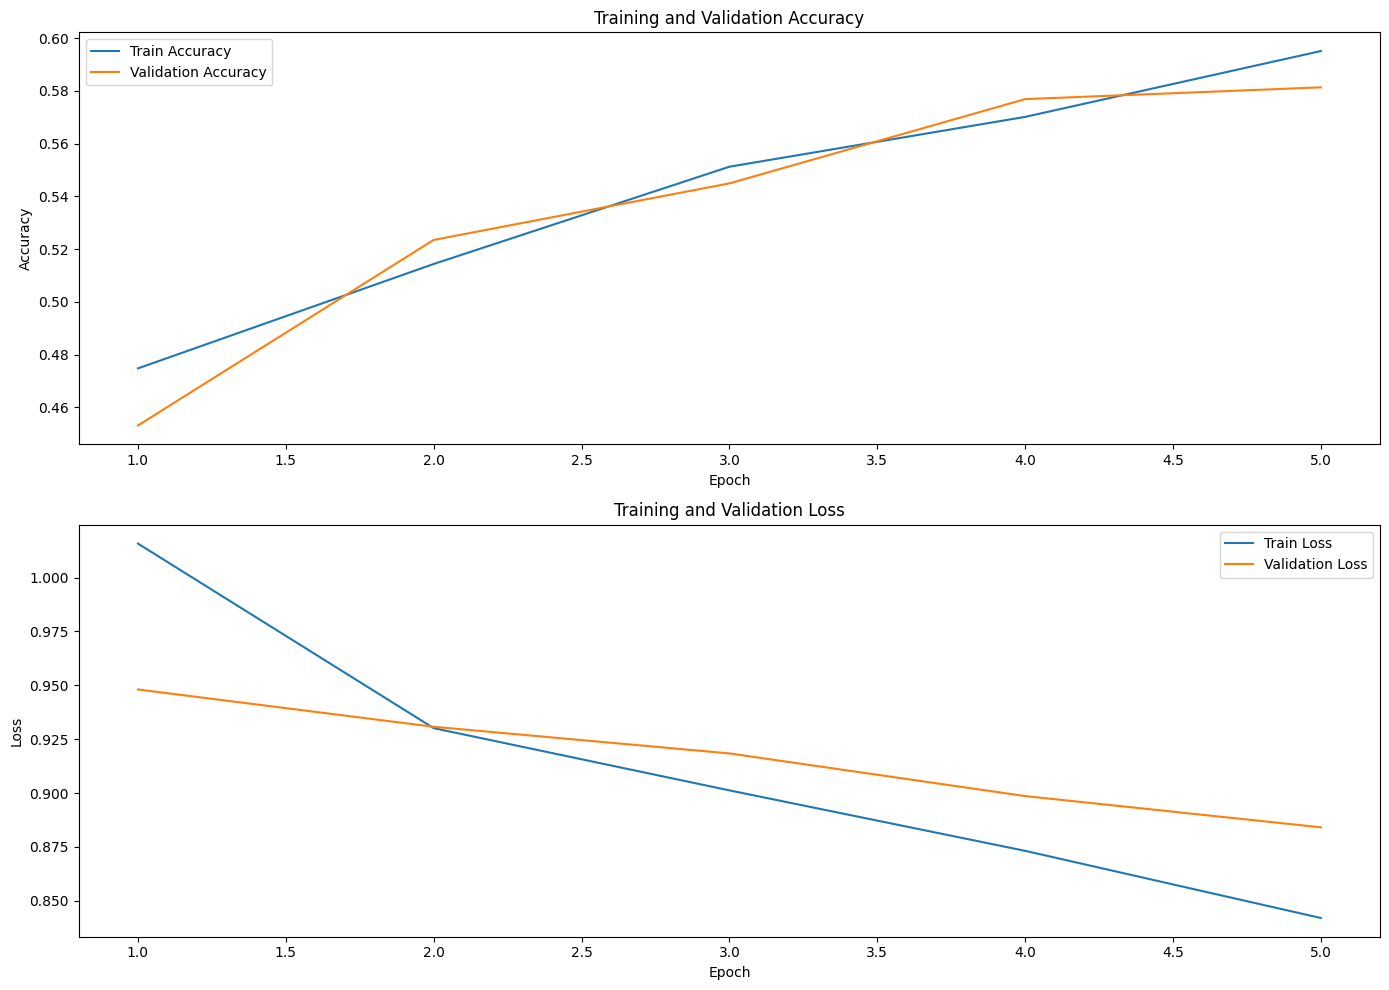

In [33]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1) 
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies1, label='Train Accuracy')
plt.plot(epochs, val_accuracies1, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, train_losses1, label='Train Loss')
plt.plot(epochs, val_losses1, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
def evaluate_model_on_test(model, dataloader, device):
    model.eval()
    losses = []
    accuracies = []
    all_labels = []
    all_predictions = []
    
    for batch in dataloader:
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            # Accumulate loss
            losses.append(loss.item())

            # Calculate accuracy
            batch_accuracy = calculate_accuracy(logits, labels)
            accuracies.append(batch_accuracy.item())

            # Store labels and predictions for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())

    avg_loss = np.mean(losses)
    avg_accuracy = np.mean(accuracies)

    return avg_loss, avg_accuracy, all_labels, all_predictions

In [35]:
test_loss1, test_accuracy1, true_labels1, predicted_labels1 = evaluate_model_on_test(model, test_dataloader, device)

print(f"Test Loss: {test_loss1}, Test Accuracy: {test_accuracy1}")

Test Loss: 0.8833867090529409, Test Accuracy: 0.59013238960299


In [36]:
true_labels1 = np.array(true_labels1)
predicted_labels1 = np.array(predicted_labels1)

# Find indices where predictions do not match true labels
incorrect_indices1 = np.where(true_labels1 != predicted_labels1)[0]

# Print some of the incorrectly predicted samples
num_samples = 5 
print("\nSome incorrectly predicted samples:")
for idx in incorrect_indices1[:num_samples]:
    print(f"True Label: {true_labels1[idx]}, Predicted Label: {predicted_labels1[idx]}")
    print(f"Text: {test_df['processed_text'].iloc[idx]}")
    print("")


Some incorrectly predicted samples:
True Label: 0, Predicted Label: 2
Text: چیزا نمیتونه باشه

True Label: 2, Predicted Label: 1
Text: موارد نامیده دستگاه هواو شرایط فراه نموده_اس آن خواهد_نمود

True Label: 2, Predicted Label: 1
Text: می‌دان گوش ۶ پشتیبان سیس رییس شرک سامسونگ معرف نو ۲ دربار دست‌نیافتن ارزو دار روز گوشی سامسونگ استفاده

True Label: 1, Predicted Label: 2
Text: دوربین نمایشگر ۳ اینچ قرار رزولوشن ۲۳۰۰۰۰ نقطه ارائه

True Label: 1, Predicted Label: 2
Text: اجرا باز گرافیک داشته_باش



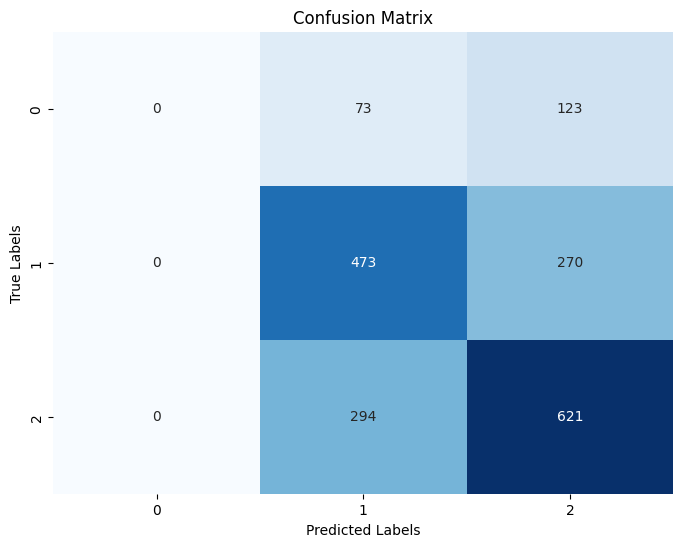

In [37]:
cm = confusion_matrix(true_labels1, predicted_labels1)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [38]:
f1_1 = f1_score(true_labels1, predicted_labels1, average='weighted')

print(f"Weighted F1 Score: {f1_1}")

Weighted F1 Score: 0.5572521612387006


## FaBert - augmented (using back translation)

In [39]:
translator = Translator()

def back_translate(text, src_lang='fa', interim_lang='en'):
    if text:
        try:
            translated = translator.translate(text, src=src_lang, dest=interim_lang).text
            time.sleep(1)
            back_translated = translator.translate(translated, src=interim_lang, dest=src_lang).text
            return back_translated
        except Exception as e:
            print(f"Translation error: {e}")
            return text
    else:
        return ''

train_df['back_translated'] = train_df['processed_text'].apply(lambda x: back_translate(x, src_lang='fa', interim_lang='en'))

In [40]:
samples = train_df[['processed_text', 'back_translated']].sample(10)
print(samples)

                                         processed_text  \
3593               نکته درسته گوش گوشی تره ب بازده داره   
3931                 دست‌ک باند تاریک روشن دیده_نمی‌شود   
3992            براحت دس میشه درصد افتادن تبلت دیگه هست   
3853  ۳ -پردازنده مرکز پردازنده مرکز کنسول ۳۶۰ نا رس...   
3248                     صفحه نما گوش صفحه نما ۴ ۳ اینچ   
2168  صد صد گوش آیفون نمی‌تواند اجازه معرف اس پنج نم...   
2                                           اهم گوش فرو   
3201  واید ۱۸ میلی ۲ ۰ نرمال ۳۵ میلی‌متر ۱ ۴ ۶۰ میلی...   
668                               چین دکمه کنترل دوربین   
800                                                بگذر   

                                        back_translated  
3593              نکته درست این است که هدفون موثرتر است  
3931                    اما نوار تاریک قابل مشاهده نیست  
3992  لمس آن آسان است، درصد ریزش تبلت دیگری نیز وجود...  
3853  3- پردازنده مرکزی توسط مایکروسافت به طور غیر ر...  
3248                           صفحه نمایش گوشی 4 3 اینچ  
21

In [41]:
concatenated_values = pd.concat([train_df['processed_text'], train_df['back_translated']])
labels = pd.concat([train_df['label'], train_df['label']])

augmented_df = pd.DataFrame({'text': concatenated_values, 'label': labels})
augmented_df = augmented_df.reset_index(drop=True)

In [42]:
augmented_df.head()

,text,label
0,۱۰ ر ۲ گیگابایت بهره می‌برد,1
1,دوربین ورزش ویژگی بهره ببرد دوربین فیلم‌بردار ...,1
2,اهم گوش فرو,2
3,سخ افزار سنسورا,2
4,هس ۲۰۱۲ سامسونگ معرفی‌شده,2


In [43]:
print(f"Number of comments after augmentation: {len(augmented_df)}")

Number of comments after augmentation: 8896


In [44]:
train_dataset = TextDataset(augmented_df['text'], augmented_df['label'], tokenizer, max_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [45]:
tokenizer = AutoTokenizer.from_pretrained("sbunlp/fabert")
model = AutoModelForSequenceClassification.from_pretrained("sbunlp/fabert", num_labels=3)
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sbunlp/fabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
for param in model.parameters():
    param.requires_grad = False
    
for param in model.classifier.parameters():
    param.requires_grad = True
    
for param in model.bert.encoder.layer[-1].parameters():
    param.requires_grad = True

In [48]:
def evaluate_model2(model, dataloader, device):
    model.eval()
    losses = []
    accuracies = []
    for batch in dataloader:
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            # Accumulate loss
            losses.append(loss.item())

            # Calculate accuracy
            batch_accuracy = calculate_accuracy(logits, labels)
            accuracies.append(batch_accuracy.item())

    avg_loss = np.mean(losses)
    avg_accuracy = np.mean(accuracies)

    return avg_loss, avg_accuracy


model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    epoch_train_accuracy = 0.0

    # Training loop
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        # Move tensors to the device explicitly
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumulate training loss and accuracy
        epoch_train_loss += loss.item()
        logits = outputs.logits
        batch_accuracy = calculate_accuracy(logits, labels)
        epoch_train_accuracy += batch_accuracy.item()

    epoch_train_loss /= len(train_dataloader)
    epoch_train_accuracy /= len(train_dataloader)
    train_losses2.append(epoch_train_loss)
    train_accuracies2.append(epoch_train_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss}, Train Accuracy: {epoch_train_accuracy}")

    # Evaluation on validation set
    epoch_val_loss, epoch_val_accuracy = evaluate_model2(model, val_dataloader, device)
    val_losses2.append(epoch_val_loss)
    val_accuracies2.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {epoch_val_accuracy}")

Epoch 1/5, Train Loss: 1.095371065165499, Train Accuracy: 0.43131744604316546
Epoch 1/5, Validation Loss: 1.097017661162785, Validation Accuracy: 0.4237103174839701
Epoch 2/5, Train Loss: 1.0954106808137551, Train Accuracy: 0.4441321942446043
Epoch 2/5, Validation Loss: 1.097017661162785, Validation Accuracy: 0.4237103174839701
Epoch 3/5, Train Loss: 1.0954106788841083, Train Accuracy: 0.4441321942446043
Epoch 3/5, Validation Loss: 1.097017661162785, Validation Accuracy: 0.4237103174839701
Epoch 4/5, Train Loss: 1.0954106748104095, Train Accuracy: 0.4441321942446043
Epoch 4/5, Validation Loss: 1.097017661162785, Validation Accuracy: 0.4237103174839701
Epoch 5/5, Train Loss: 1.095410679527324, Train Accuracy: 0.4441321942446043
Epoch 5/5, Validation Loss: 1.097017661162785, Validation Accuracy: 0.4237103174839701


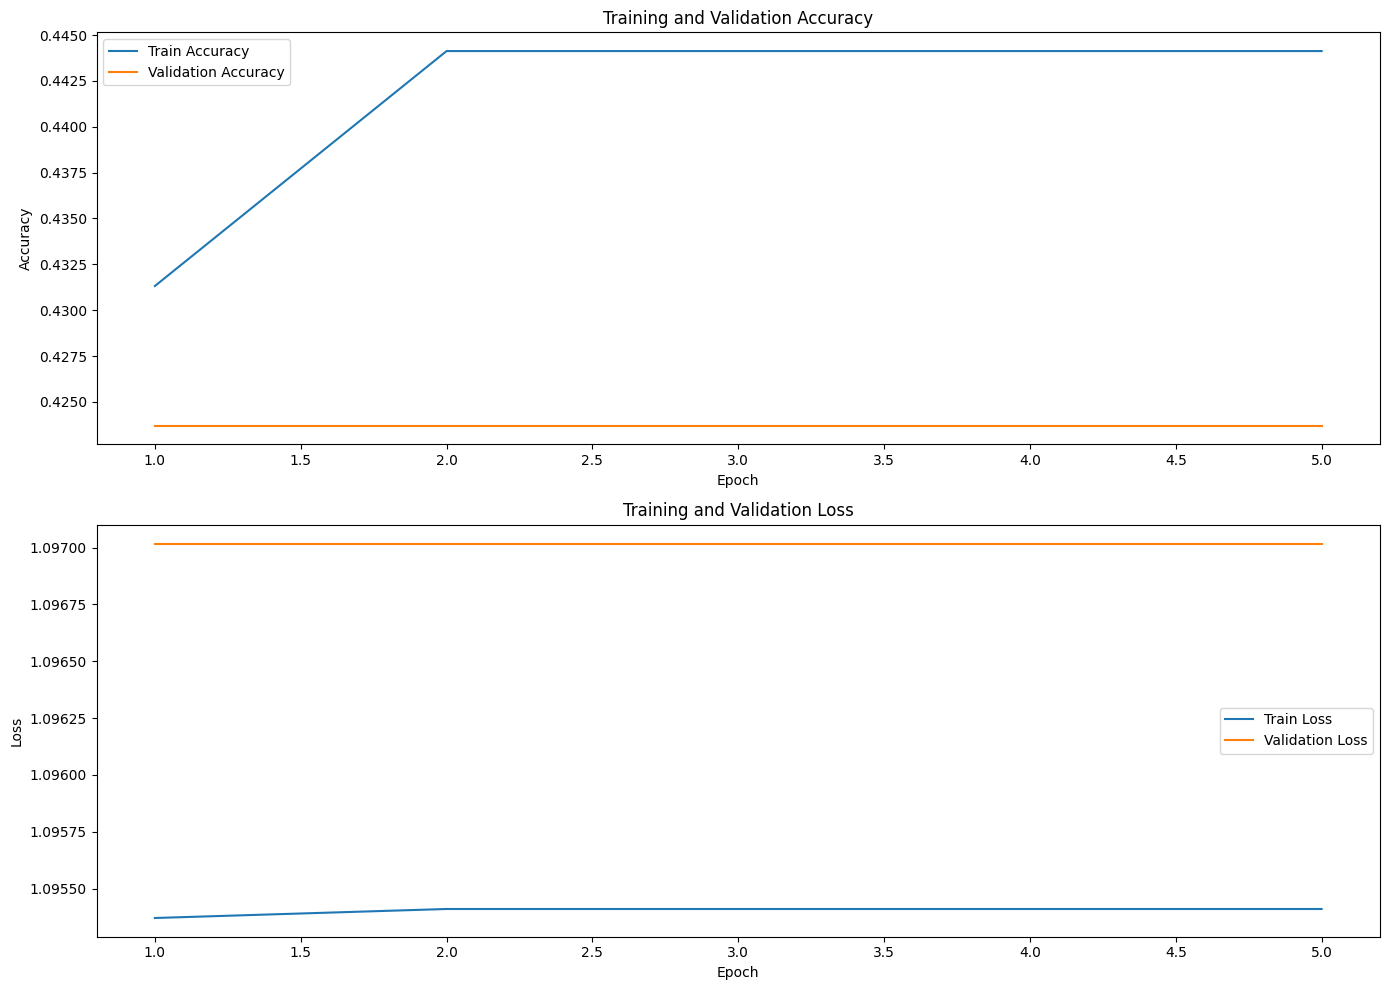

In [49]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1) 
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies2, label='Train Accuracy')
plt.plot(epochs, val_accuracies2, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, train_losses2, label='Train Loss')
plt.plot(epochs, val_losses2, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [51]:
test_loss2, test_accuracy2, true_labels2, predicted_labels2 = evaluate_model_on_test(model, test_dataloader, device)

print(f"Test Loss: {test_loss2}, Test Accuracy: {test_accuracy2}")

Test Loss: 1.0931567950495358, Test Accuracy: 0.4724445815744071


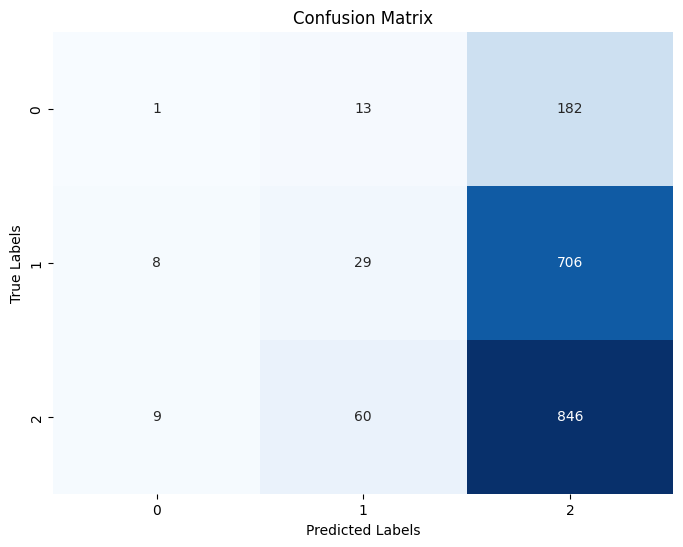

In [52]:
cm = confusion_matrix(true_labels2, predicted_labels2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [53]:
f1_2 = f1_score(true_labels2, predicted_labels2, average='weighted')

print(f"Weighted F1 Score: {f1_2}")

Weighted F1 Score: 0.34372707840750255


In [54]:
true_labels2 = np.array(true_labels2)
predicted_labels2 = np.array(predicted_labels2)

incorrect_indices2 = np.where(true_labels2 != predicted_labels2)[0]

num_samples_to_show = 5

print("\nSome incorrectly predicted samples:")
for idx in incorrect_indices2[:num_samples_to_show]:
    print(f"True Label: {true_labels2[idx]}, Predicted Label: {predicted_labels2[idx]}")
    print(f"Text: {test_df['processed_text'].iloc[idx]}")
    print("")


Some incorrectly predicted samples:
True Label: 2, Predicted Label: 1
Text: اندازه داره

True Label: 0, Predicted Label: 1
Text: چیزا نمیتونه باشه

True Label: 1, Predicted Label: 2
Text: دوربین نمایشگر ۳ اینچ قرار رزولوشن ۲۳۰۰۰۰ نقطه ارائه

True Label: 1, Predicted Label: 2
Text: همانند ۵ بدنه پنج آلومینیو یکپارچه ساخته‌شده جلو دستگاه یک‌لایه شیشه صفحه نما قرار داده‌شده

True Label: 1, Predicted Label: 2
Text: اجرا باز گرافیک داشته_باش



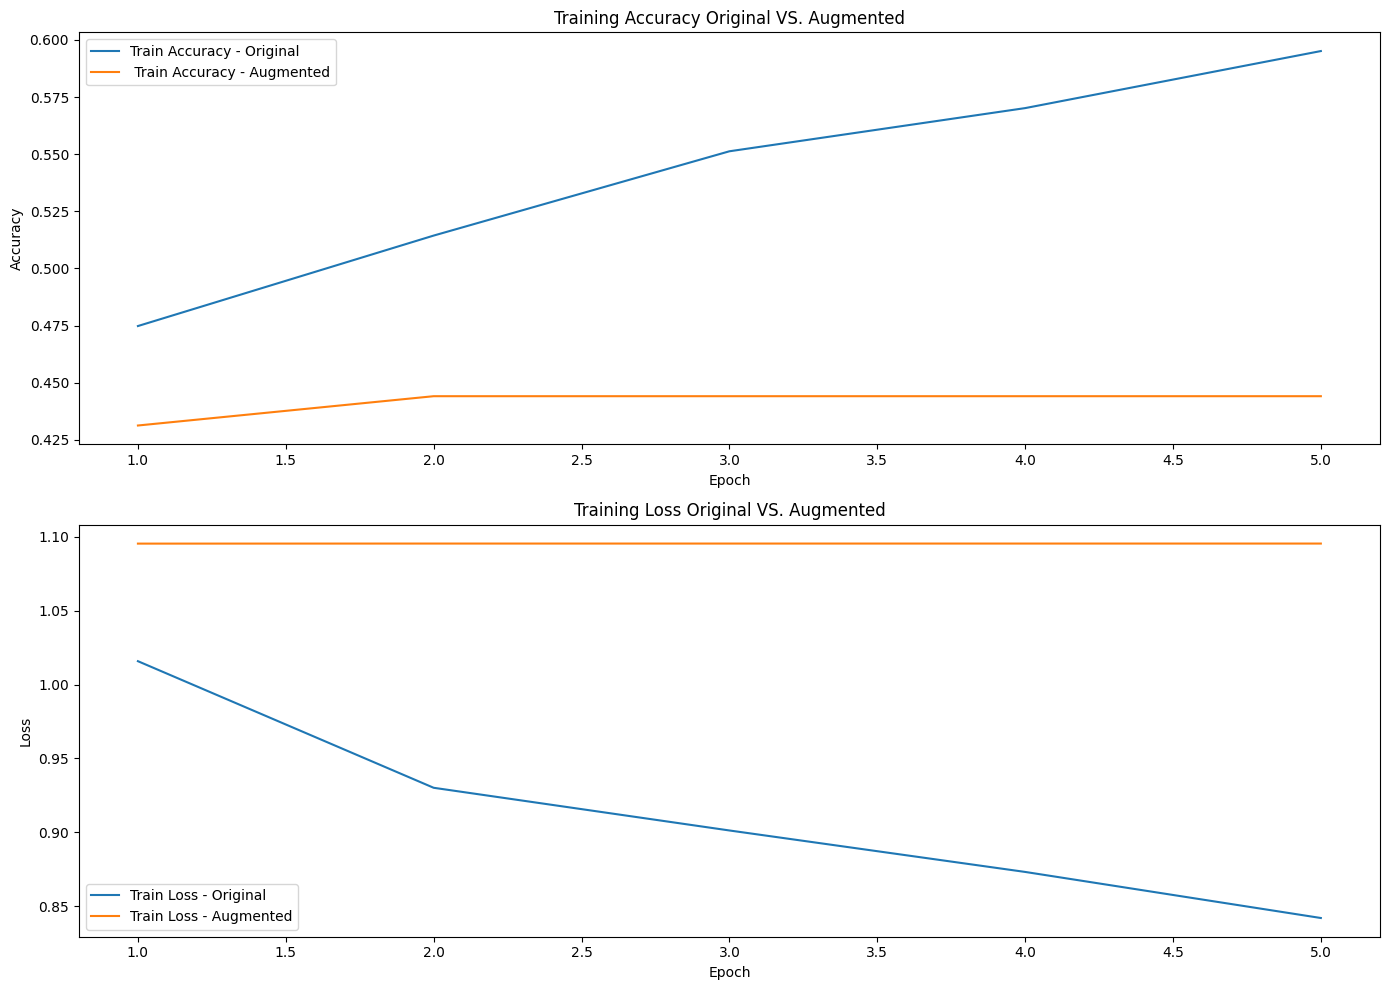

In [56]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies1, label='Train Accuracy - Original')
plt.plot(epochs, train_accuracies2, label=' Train Accuracy - Augmented')
plt.title('Training Accuracy Original VS. Augmented')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, train_losses1, label='Train Loss - Original')
plt.plot(epochs, train_losses2, label='Train Loss - Augmented')
plt.title('Training Loss Original VS. Augmented')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

plt.show()

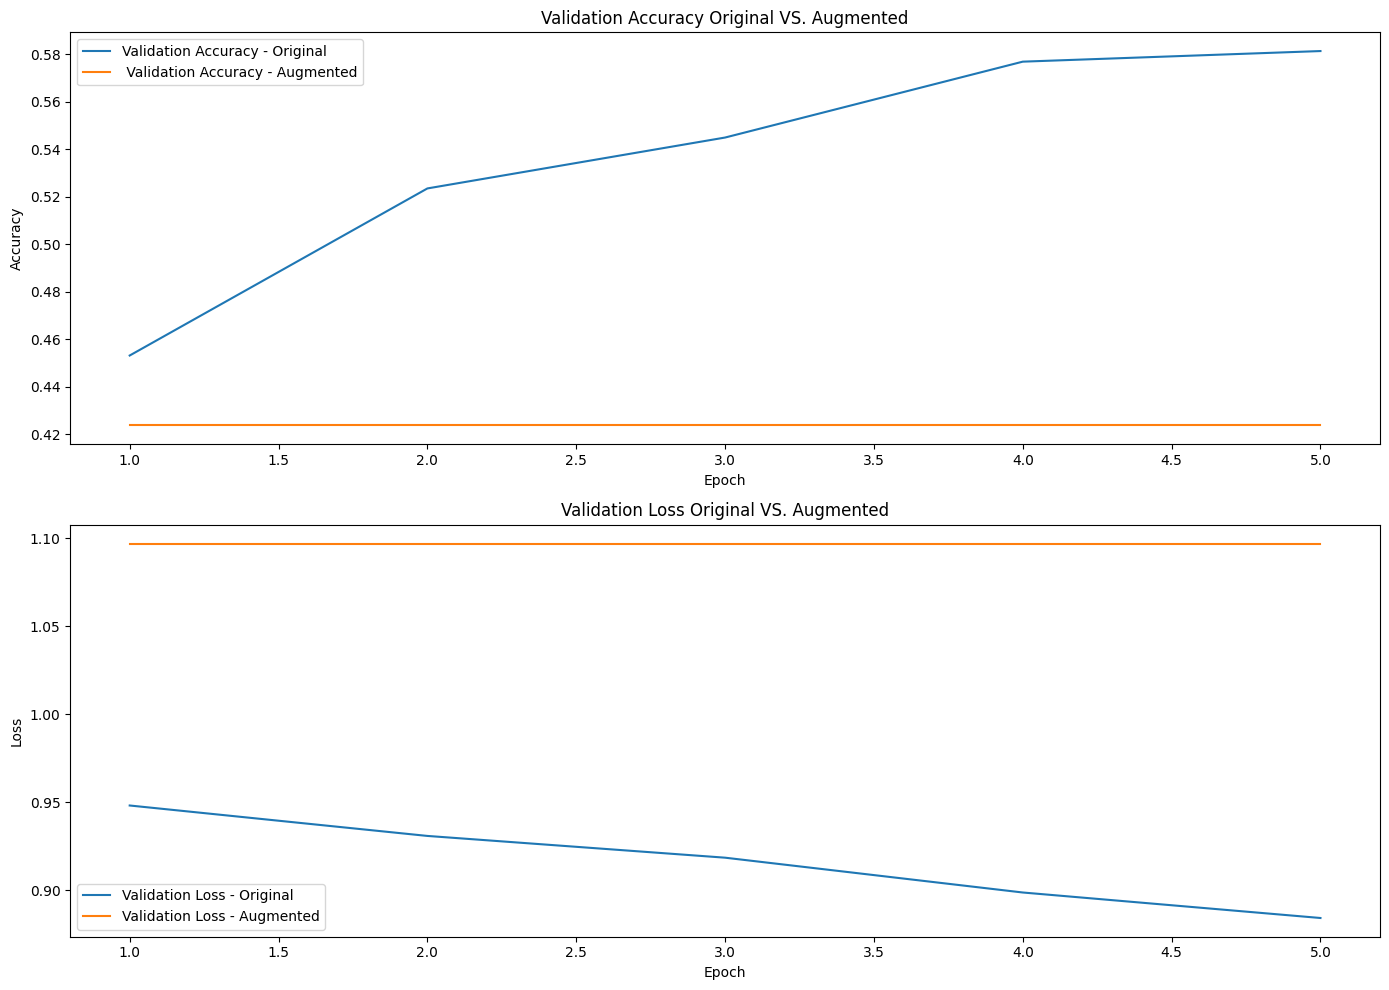

In [57]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
epochs = range(1, num_epochs + 1)
plt.plot(epochs, val_accuracies1, label='Validation Accuracy - Original')
plt.plot(epochs, val_accuracies2, label=' Validation Accuracy - Augmented')
plt.title('Validation Accuracy Original VS. Augmented')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, val_losses1, label='Validation Loss - Original')
plt.plot(epochs, val_losses2, label='Validation Loss - Augmented')
plt.title('Validation Loss Original VS. Augmented')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

plt.show()